# Autograd (backpropagation)

In [162]:
import torch

# Create tensors.
x = torch.tensor(1., requires_grad=True)
w = torch.tensor(2., requires_grad=True)
b = torch.tensor(3., requires_grad=True)

# Build a computational graph.
y = w * x + b    # y = 2 * x + 3

$$y = w \cdot x + b$$

In [163]:
# Compute gradients.
y.backward()

# Print out the gradients.
print(w.grad)    # w.grad = 1
print(x.grad)    # x.grad = 2
print(b.grad)    # b.grad = 1

tensor(1.)
tensor(2.)
tensor(1.)


x = torch.tensor(1., requires_grad=True)
w = torch.tensor(2., requires_grad=True)
b = torch.tensor(3., requires_grad=True)

$$y(w, x, b) = w * x + b$$

$$\dfrac{\partial y}{\partial w} = x = 1$$

$$\dfrac{\partial y}{\partial x} = w = 2$$

$$\dfrac{\partial y}{\partial b} = 1 = 1$$

### How does that work?

$$\alpha(w, x) = w \cdot x$$

$$\beta(\alpha, b) = \alpha + b$$

$$y(w, x, b) = \beta(\alpha(w, x), b)$$

---

$$\beta(\alpha, b) = \alpha + b$$

$$\dfrac{\partial \beta}{\partial \alpha}(\alpha, b) = 1$$

$$\dfrac{\partial \beta}{\partial b}(\alpha, b) = 1$$

---

$$\alpha(w, x) = w \cdot x$$

$$\dfrac{\partial \alpha}{\partial w}(w, x) = x$$

$$\dfrac{\partial \alpha}{\partial x}(w, x) = w$$

--

$$y(w, x, b) = \beta(\alpha(w, x), b)$$

$$\dfrac{\partial y}{\partial w}(w, x, b) = \dfrac{\partial \beta}{\partial \alpha}(\alpha(w, x), b) \cdot \dfrac{\partial \alpha}{\partial w}(w, x) = x$$

So all we need to do is to follow the "computation graph" backwards and multiply partial derivatives. We can use the forward pass we've already done to substitute values into partial derivatives.

In [173]:
class Var:
    def __init__(self, value):
        self.value = value
        self.grad = 0
        
    def __add__(self, that):
        return Add(self, that)
    
    def __mul__(self, that):
        return Mul(self, that)
    
    def backward(self, g=1):
        self.grad += g

class Add(Var):
    def __init__(self, left, right):
        Var.__init__(self, left.value + right.value)
        self.left = left
        self.right = right
    
    def backward(self, g=1):
        self.grad += g
        self.left.backward(g)
        self.right.backward(g)
        
class Mul(Var):
    def __init__(self, left, right):
        Var.__init__(self, left.value * right.value)
        self.left = left
        self.right = right
        
    def backward(self, g=1):
        self.grad += g
        self.left.backward(g * self.right.value)
        self.right.backward(g * self.left.value)

In [174]:
x = Var(1)
w = Var(2)
b = Var(3)

y = w * x + b

y.backward()

print(w.value, w.grad)    # w.grad = 1
print(x.value, x.grad)    # x.grad = 2
print(b.value, b.grad)    # b.grad = 1

2 1
1 2
3 1


In [175]:
x = Var(1)
y = x * x
y.backward()

print(x.value, x.grad)    # x.grad = 2

1 2


# Side-note: forward mode differentiation

$$(a + i b) \cdot (c + i d) = (a c - b d) + i (a d + b c)$$
$$(a + \delta \cdot b) \cdot (c + \delta \cdot d) = (a c + \delta^2 b d) + \delta (a d + b c) \approx a c + \delta (a d + b c)$$
$$(a + \delta \cdot a') \cdot (c + \delta \cdot c') = a c + \delta (a c' + a' c) = a c + \delta (a c)'$$
$$(a + \delta \cdot a') + (c + \delta \cdot c') = a + c + \delta (a' + c') = a + c + \delta (a + c)'$$
$$f(a + \delta \cdot b) = f(a) + f'(a) \delta \cdot b$$

$$exp(a + \delta \cdot b) = 1 + (a + \delta \cdot b) + (a + \delta \cdot b)^2 / 2 + \ldots = exp(a) + \delta \cdot b \cdot exp(a)$$

In [180]:
class Dual:
    def __init__(self, value, grad=0):
        self.value = value
        self.grad = grad
        
    def __add__(self, that):
        return Dual(
            self.value + that.value, 
            self.grad  + that.grad)
    
    def __mul__(self, that):
        return Dual(
            self.value * that.value, 
            self.grad * that.value + that.grad * self.value)

a = Dual(1, 0) # a(t) = a_0
x = Dual(1, 1) # x(t) = t
y = x * a
print(y.value, y.grad)

1 1


# Optimization


0 6.464632034301758
tensor(0.) tensor(-2.7996)
tensor(0.) tensor(-4.7848)


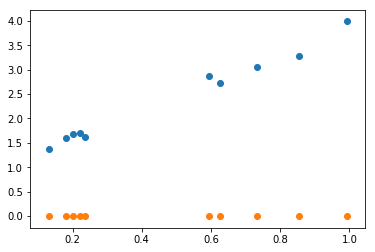


50 6.092432022094727
tensor(0.0498) tensor(-2.7203)
tensor(0.0498) tensor(-4.6376)

100 5.736283779144287
tensor(0.0990) tensor(-2.6421)
tensor(0.0989) tensor(-4.4924)


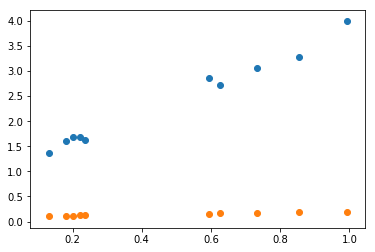


150 5.39630126953125
tensor(0.1475) tensor(-2.5650)
tensor(0.1473) tensor(-4.3495)

200 5.071995735168457
tensor(0.1953) tensor(-2.4891)
tensor(0.1949) tensor(-4.2088)


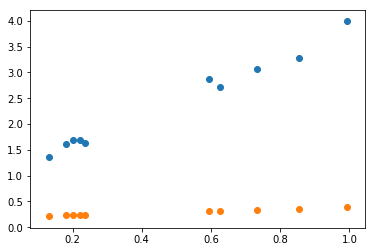


250 4.762879371643066
tensor(0.2424) tensor(-2.4145)
tensor(0.2417) tensor(-4.0703)

300 4.468471527099609
tensor(0.2887) tensor(-2.3410)
tensor(0.2877) tensor(-3.9340)


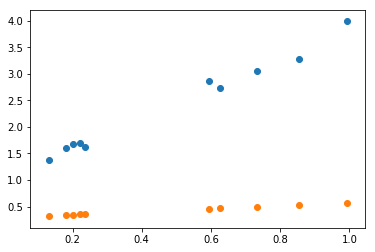

In [185]:
import numpy as np
import matplotlib.pyplot as plt

data_x = np.sort(np.random.uniform(size=10))
data_y = data_x * 3.0 + 1.0 + np.random.normal(size=10) * 0.1

x  = torch.tensor(data_x, requires_grad=False, dtype=torch.float)
y0 = torch.tensor(data_y, requires_grad=False, dtype=torch.float)
w = torch.tensor(0., requires_grad=True, dtype=torch.float)
b = torch.tensor(0., requires_grad=True, dtype=torch.float)

optimizer = torch.optim.Adam([w, b], lr=0.001)

for i in range(301):
    y = w * x + b
    
    # e = E[(w * x + b - y0)^2]
    loss = torch.sum((y - y0) ** 2. / 10.0)
    
    # de / dw, de / db
    loss.backward()
    
    p = (lambda *x: print(*x)) if i % 50 == 0 else (lambda *x: None)
    p()
    p(i, loss.item())
    p(w.data, w.grad)
    p(b.data, b.grad)
    
    optimizer.step()
    w.grad.zero_()
    b.grad.zero_()
    
    if i % 100 == 0:
        plt.scatter(data_x, y0.numpy())
        plt.scatter(data_x, y.detach().numpy())
        plt.show()

# Training a digit classifier

In [186]:
import torchvision
import torchvision.transforms as transforms

# MNIST dataset (images and labels)
train_dataset = torchvision.datasets.MNIST(
    root='./torch_data', 
    train=True, 
    transform=transforms.ToTensor(),
    download=True)

test_dataset = torchvision.datasets.MNIST(
    root='./torch_data', 
    train=False, 
    transform=transforms.ToTensor())

batch_size = 100

# Data loader (input pipeline)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=batch_size, 
    shuffle=False)

In [188]:
# next(enumerate(train_loader))

In [194]:
# Hyper-parameters 
input_size = 28*28
num_classes = 10
num_epochs = 5
learning_rate = 0.001

# Logistic regression model
# output_j = sigmoid(b_j + w_ij * x_i)
model = nn.Linear(input_size, num_classes)

# Loss and optimizer
# nn.CrossEntropyLoss() computes softmax internally
# p(output=i | x) = exp(x_i) / (sum_j exp(x_j))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Reshape images to (batch_size, input_size)
        images = images.reshape(-1, 28*28)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels) + 1 * torch.sum(model.weight.abs()) / input_size / num_classes
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Epoch [1/5], Step [100/600], Loss: 0.7895
Epoch [1/5], Step [200/600], Loss: 0.6091
Epoch [1/5], Step [300/600], Loss: 0.6407
Epoch [1/5], Step [400/600], Loss: 0.5279
Epoch [1/5], Step [500/600], Loss: 0.5040
Epoch [1/5], Step [600/600], Loss: 0.4633
Epoch [2/5], Step [100/600], Loss: 0.5228
Epoch [2/5], Step [200/600], Loss: 0.2882
Epoch [2/5], Step [300/600], Loss: 0.4320
Epoch [2/5], Step [400/600], Loss: 0.4040
Epoch [2/5], Step [500/600], Loss: 0.3893
Epoch [2/5], Step [600/600], Loss: 0.4665
Epoch [3/5], Step [100/600], Loss: 0.2542
Epoch [3/5], Step [200/600], Loss: 0.4451
Epoch [3/5], Step [300/600], Loss: 0.2764
Epoch [3/5], Step [400/600], Loss: 0.4899
Epoch [3/5], Step [500/600], Loss: 0.4051
Epoch [3/5], Step [600/600], Loss: 0.4238
Epoch [4/5], Step [100/600], Loss: 0.3639
Epoch [4/5], Step [200/600], Loss: 0.3514
Epoch [4/5], Step [300/600], Loss: 0.2988
Epoch [4/5], Step [400/600], Loss: 0.2969
Epoch [4/5], Step [500/600], Loss: 0.3946
Epoch [4/5], Step [600/600], Loss:

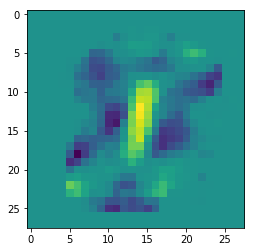

In [198]:
plt.imshow(model.weight[1].reshape((28, 28)).detach().numpy())